<a href="https://colab.research.google.com/github/skj092/Computer_Vision_Lab/blob/main/Global_Wheat_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
main_dir = "/content/drive/MyDrive/ML"

# Downloading the dataset

In [ ]:
!mv kaggle.json /root/.kaggle/

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
cd /content/drive/MyDrive/ML

/content/drive/MyDrive/ML


In [ ]:
!mkdir /content/drive/MyDrive/ML/data

In [ ]:
cd /content/drive/MyDrive/ML/data

/content/drive/MyDrive/ML/data


In [ ]:
!kaggle competitions download -c global-wheat-detection

 98% 593M/607M [00:04<00:00, 92.0MB/s]
100% 607M/607M [00:04<00:00, 132MB/s] 


In [ ]:
!unzip global-wheat-detection.zip

In [ ]:
!rm global-wheat-detection.zip

# Setting up Envieonment 

In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 177821, done.
remote: Counting objects: 100% (10206/10206), done.
remote: Compressing objects: 100% (635/635), done.
remote: Total 177821 (delta 9612), reused 10084 (delta 9550), pack-reused 167615
Receiving objects: 100% (177821/177821), 350.71 MiB | 30.27 MiB/s, done.
Resolving deltas: 100% (159200/159200), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
!pip uninstall opencv-python-headless -y

In [3]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.2 MB/s 


In [4]:
root_dir = "/content/drive/MyDrive/ML"

In [5]:
# Importing necessary libraries 

import os 
from pathlib import Path 
import xml.etree.ElementTree as ET 
from torch.utils.data import Dataset
from PIL import Image
import torch 
import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import cv2 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
import pandas as pd 
import ast
from sklearn import model_selection

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T

# Define Transform

In [6]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Dataset and DataLoader

In [13]:
def prepare_data(df):
    df['bbox'] = df['bbox'].apply(ast.literal_eval)
    df = df.groupby('image_id')['bbox'].apply(list).reset_index(name='bboxes')
    return df

In [7]:
class WheatDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform 
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        image_id, bboxes = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, image_id+'.jpg')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        boxes = []
        for bbox in bboxes:
            x1 = bbox[0]
            y1 = bbox[1]
            x2 = x1+bbox[2]
            y2 = y1+bbox[3]
            bbox = [x1, y1, x2, y2]
            boxes.append(bbox)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        bboxes = torch.as_tensor(boxes, dtype=torch.float32)
        target = {'boxes': bboxes, 'labels': labels}
        return image, target

In [40]:
def show_image_bbox(img, target):
    plt.figure(figsize=(10, 10))
    bboxes = target['boxes']
    label = target['labels']
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 51, 51), 4)
        cv2.putText(img, 'Wheat', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
    plt.imshow(img)
    plt.show()

In [41]:
# train_dir = os.path.join(root_dir, 'data/train')
# df = pd.read_csv(os.path.join(root_dir, 'data/train.csv'))
# df = prepare_data(df)
# ds = WheatDataset(df, train_dir)

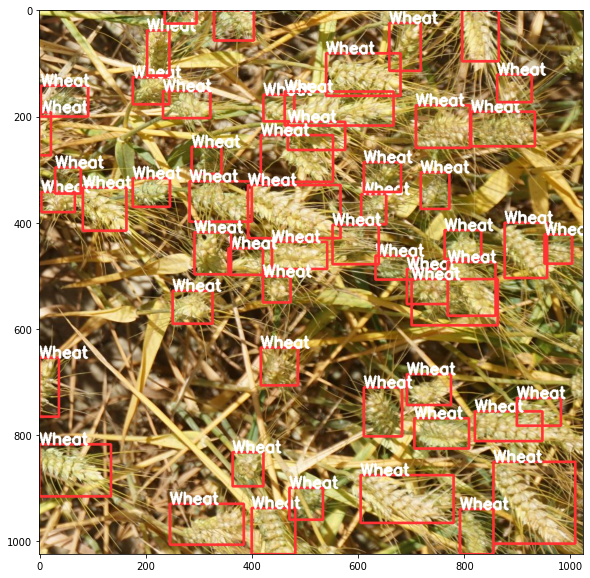

In [42]:
img, target = ds[0]
show_image_bbox(img, target)

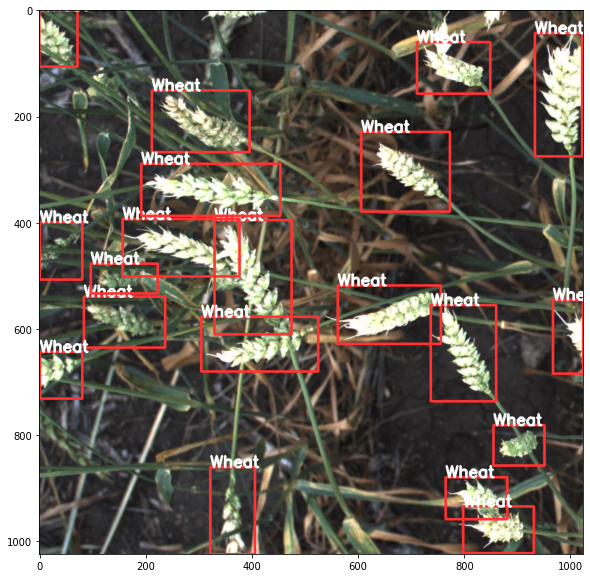

In [43]:
img, target = ds[1]
show_image_bbox(img, target)

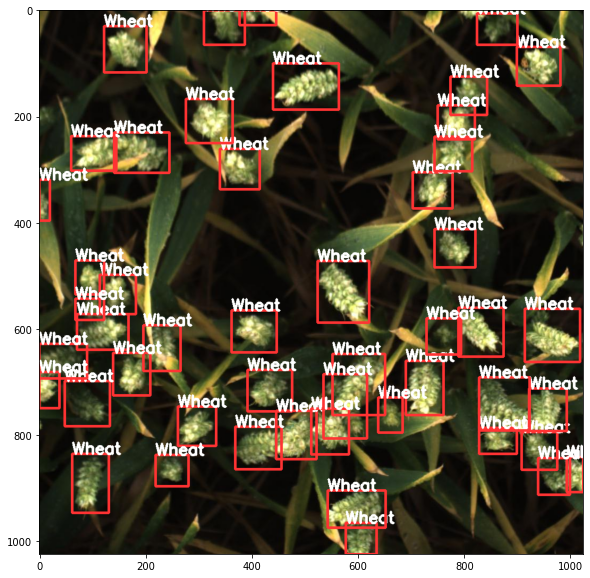

In [44]:
img, target = ds[10]
show_image_bbox(img, target)

# Model

In [45]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_object_detection_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Testing On One Batch

In [14]:
train_dir = os.path.join(root_dir, 'data/train')
df = pd.read_csv(os.path.join(root_dir, 'data/train.csv'))
df = prepare_data(df)
ds = WheatDataset(df, train_dir, transform=get_transform(train=True))
dl = DataLoader(ds, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)
images,targets = next(iter(dl))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
model = get_object_detection_model(2)
predictions = model(images, targets)
predictions

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

{'loss_box_reg': tensor(0.4676, grad_fn=<DivBackward0>),
 'loss_classifier': tensor(0.5736, grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(4.6037, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.2396, grad_fn=<DivBackward0>)}

In [46]:
# config 

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
df = pd.read_csv(os.path.join(root_dir, 'data/train.csv'))
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=42)
df_train = prepare_data(df_train)
df_valid = prepare_data(df_valid)

# datasets 
image_dir = os.path.join(root_dir, 'data/train')
train_ds = WheatDataset(df_train, image_dir, transform=get_transform(train=True))
valid_ds = WheatDataset(df_valid, image_dir, transform=get_transform(train=False))

# dataloaders
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=2, shuffle=False, collate_fn=utils.collate_fn)

# model
model = get_object_detection_model(2)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# train the model
num_epochs = 10
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation set
    evaluate(model, valid_dl, device=device)

Epoch: [0]  [   0/1686]  eta: 3:30:20  lr: 0.000010  loss: 2.8257 (2.8257)  loss_classifier: 0.8287 (0.8287)  loss_box_reg: 0.4823 (0.4823)  loss_objectness: 1.4153 (1.4153)  loss_rpn_box_reg: 0.0994 (0.0994)  time: 7.4857  data: 0.7192  max mem: 1639
Epoch: [0]  [  10/1686]  eta: 0:46:47  lr: 0.000060  loss: 3.4597 (4.0642)  loss_classifier: 0.7747 (0.7710)  loss_box_reg: 0.6267 (0.6177)  loss_objectness: 2.0436 (2.5266)  loss_rpn_box_reg: 0.1493 (0.1489)  time: 1.6751  data: 0.7215  max mem: 1903
Epoch: [0]  [  20/1686]  eta: 0:40:07  lr: 0.000110  loss: 3.0187 (3.1672)  loss_classifier: 0.6728 (0.6826)  loss_box_reg: 0.6134 (0.5949)  loss_objectness: 1.5046 (1.7427)  loss_rpn_box_reg: 0.1493 (0.1469)  time: 1.1430  data: 0.7684  max mem: 1903
Epoch: [0]  [  30/1686]  eta: 0:36:36  lr: 0.000160  loss: 1.9226 (2.7191)  loss_classifier: 0.5517 (0.6266)  loss_box_reg: 0.5475 (0.5879)  loss_objectness: 0.5722 (1.3652)  loss_rpn_box_reg: 0.1426 (0.1393)  time: 1.1349  data: 0.7574  max me